# Data Import

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D

In [2]:
dataset_path = '/kaggle/input/sncb-data-augumentation/enriched_cleaned_ar41_for_ulb.csv'

# Check if the file exists before trying to read it
if os.path.exists(dataset_path):
    data = pd.read_csv(dataset_path)

    # Display the basic information and the first few rows of the dataframe
    data_info = data.info()
    data_head = data.head()

    # If you want to print the information to the console
    print(data_info)
    print(data_head)
else:
    print(f"The file {dataset_path} does not exist.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17677337 entries, 0 to 17677336
Data columns (total 30 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   timestamps_UTC      object 
 2   mapped_veh_id       float64
 3   lat                 float64
 4   lon                 float64
 5   RS_E_InAirTemp_PC1  float64
 6   RS_E_InAirTemp_PC2  float64
 7   RS_E_OilPress_PC1   float64
 8   RS_E_OilPress_PC2   float64
 9   RS_E_RPM_PC1        float64
 10  RS_E_RPM_PC2        float64
 11  RS_E_WatTemp_PC1    float64
 12  RS_E_WatTemp_PC2    float64
 13  RS_T_OilTemp_PC1    float64
 14  RS_T_OilTemp_PC2    float64
 15  date                object 
 16  hour                float64
 17  dayofweek           float64
 18  weekday             object 
 19  Distance            float64
 20  Speed               float64
 21  date_hour           object 
 22  datetime            object 
 23  weather_main        object 
 24  temp                fl

# Label about Idle or Running

In [3]:
# Selecting the relevant columns for clustering
clustering_data = data[['Speed', 'RS_E_RPM_PC1', 'RS_E_RPM_PC1', 'hour']]

# Removing rows with NaN values
clustering_data_cleaned = clustering_data.dropna()

# Normalize the data
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data_cleaned)

# Applying K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(clustering_data_scaled)

# Adding the cluster labels to the original data for analysis
# Make sure 'data_parsed' is a copy of your original dataframe to add the clusters to
data_parsed = data.copy()
data_parsed = data_parsed.loc[clustering_data_cleaned.index]  # Align the indices
data_parsed['running'] = clusters

# Displaying the first few rows of the dataset with cluster labels
data_parsed.head()


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Unnamed: 0,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,...,date_hour,datetime,weather_main,temp,feels_like,pressure,humidity,wind,clouds,running
0,0,2023-01-23 07:25:08,102.0,51.02,3.77,17.0,18.0,210.0,210.0,858.0,...,2023-01-23 07:00:00,2023-01-23 07:00:00,Clouds,274.54,271.75,1035.0,92.0,2.52,100.0,0
1,1,2023-01-23 07:25:16,102.0,51.02,3.77,17.0,20.0,200.0,200.0,801.0,...,2023-01-23 07:00:00,2023-01-23 07:00:00,Clouds,274.54,271.75,1035.0,92.0,2.52,100.0,0
2,2,2023-01-23 07:25:37,102.0,51.02,3.77,19.0,20.0,193.0,207.0,803.0,...,2023-01-23 07:00:00,2023-01-23 07:00:00,Clouds,274.54,271.75,1035.0,92.0,2.52,100.0,0
3,3,2023-01-23 07:25:41,102.0,51.02,3.77,19.0,20.0,196.0,203.0,801.0,...,2023-01-23 07:00:00,2023-01-23 07:00:00,Clouds,274.54,271.75,1035.0,92.0,2.52,100.0,0
4,4,2023-01-23 07:26:10,102.0,51.02,3.77,19.0,21.0,200.0,203.0,795.0,...,2023-01-23 07:00:00,2023-01-23 07:00:00,Clouds,274.54,271.75,1035.0,92.0,2.52,100.0,0


# Visualize Runing Lable

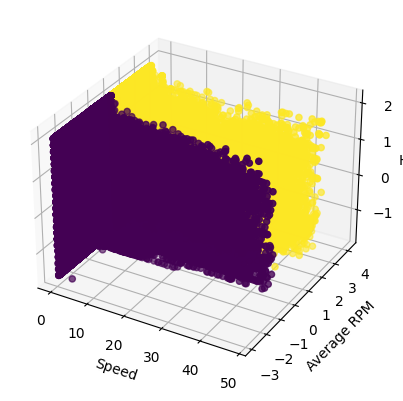

In [4]:
# Compute the average of the 'RS_E_RPM_PC' columns
rpm_avg = np.mean(clustering_data_scaled[:, 1:3], axis=1)

# Create a new dataset for 3D visualization
data_3d = np.column_stack((clustering_data_scaled[:, 0], rpm_avg, clustering_data_scaled[:, 3]))

# 3D Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_3d[:, 0], data_3d[:, 1], data_3d[:, 2], c=clusters, marker='o')

ax.set_xlabel('Speed')
ax.set_ylabel('Average RPM')
ax.set_zlabel('Hour')

plt.show()

# Naive Labling -- KMeans

In [5]:
# Define numeric and categorical columns
numeric_columns = ['mapped_veh_id', 'lat', 'lon', 'RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2', 'RS_E_OilPress_PC1', 'RS_E_OilPress_PC2', 'RS_E_RPM_PC1', 'RS_E_RPM_PC2', 'RS_E_WatTemp_PC1', 'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC1', 'RS_T_OilTemp_PC2', 'hour', 'Distance', 'Speed', 'temp', 'feels_like', 'pressure', 'humidity', 'wind', 'clouds']
categorical_columns = ['weather_main', 'weekday']

# Preprocessing process
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle null values
    ('scaler', StandardScaler())])  # Standardization

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle null values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # One Hot Coding

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)])

# Apply preprocessing
data_processed = preprocessor.fit_transform(data)

# K-Means Clusttering
kmeans = KMeans(n_clusters=2)  # Suppose we wish to separate into two groups: normal and abnormal
clusters = kmeans.fit_predict(data_processed)
data['KMeans_cluster'] = clusters

# View clustering results
print(data['KMeans_cluster'].value_counts())

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans_cluster
1    12057172
0     5620165
Name: count, dtype: int64


In [6]:
data

,Unnamed: 0,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,...,date_hour,datetime,weather_main,temp,feels_like,pressure,humidity,wind,clouds,KMeans_cluster
0,0,2023-01-23 07:25:08,102.0,51.02,3.77,17.0,18.0,210.0,210.0,858.0,...,2023-01-23 07:00:00,2023-01-23 07:00:00,Clouds,274.54,271.75,1035.0,92.0,2.52,100.0,0
1,1,2023-01-23 07:25:16,102.0,51.02,3.77,17.0,20.0,200.0,200.0,801.0,...,2023-01-23 07:00:00,2023-01-23 07:00:00,Clouds,274.54,271.75,1035.0,92.0,2.52,100.0,0
2,2,2023-01-23 07:25:37,102.0,51.02,3.77,19.0,20.0,193.0,207.0,803.0,...,2023-01-23 07:00:00,2023-01-23 07:00:00,Clouds,274.54,271.75,1035.0,92.0,2.52,100.0,0
3,3,2023-01-23 07:25:41,102.0,51.02,3.77,19.0,20.0,196.0,203.0,801.0,...,2023-01-23 07:00:00,2023-01-23 07:00:00,Clouds,274.54,271.75,1035.0,92.0,2.52,100.0,0
4,4,2023-01-23 07:26:10,102.0,51.02,3.77,19.0,21.0,200.0,203.0,795.0,...,2023-01-23 07:00:00,2023-01-23 07:00:00,Clouds,274.54,271.75,1035.0,92.0,2.52,100.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17677332,17677332,2023-09-13 17:33:03,197.0,50.40,4.45,37.0,40.0,220.0,258.0,803.0,...,2023-09-13 18:00:00,2023-09-13 18:00:00,Clouds,290.38,290.22,1021.0,79.0,3.60,20.0,1
17677333,17677333,2023-09-13 17:33:58,197.0,50.40,4.45,37.0,38.0,224.0,307.0,843.0,...,2023-09-13 18:00:00,2023-09-13 18:00:00,Clouds,290.38,290.22,1021.0,79.0,3.60,20.0,1
17677334,17677334,2023-09-13 17:34:03,197.0,50.40,4.45,37.0,38.0,224.0,307.0,841.0,...,2023-09-13 18:00:00,2023-09-13 18:00:00,Clouds,290.38,290.22,1021.0,79.0,3.60,20.0,1
17677335,17677335,2023-09-13 17:34:58,197.0,50.40,4.46,36.0,38.0,207.0,244.0,800.0,...,2023-09-13 18:00:00,2023-09-13 18:00:00,Clouds,290.38,290.22,1021.0,79.0,3.60,20.0,1


Visulization

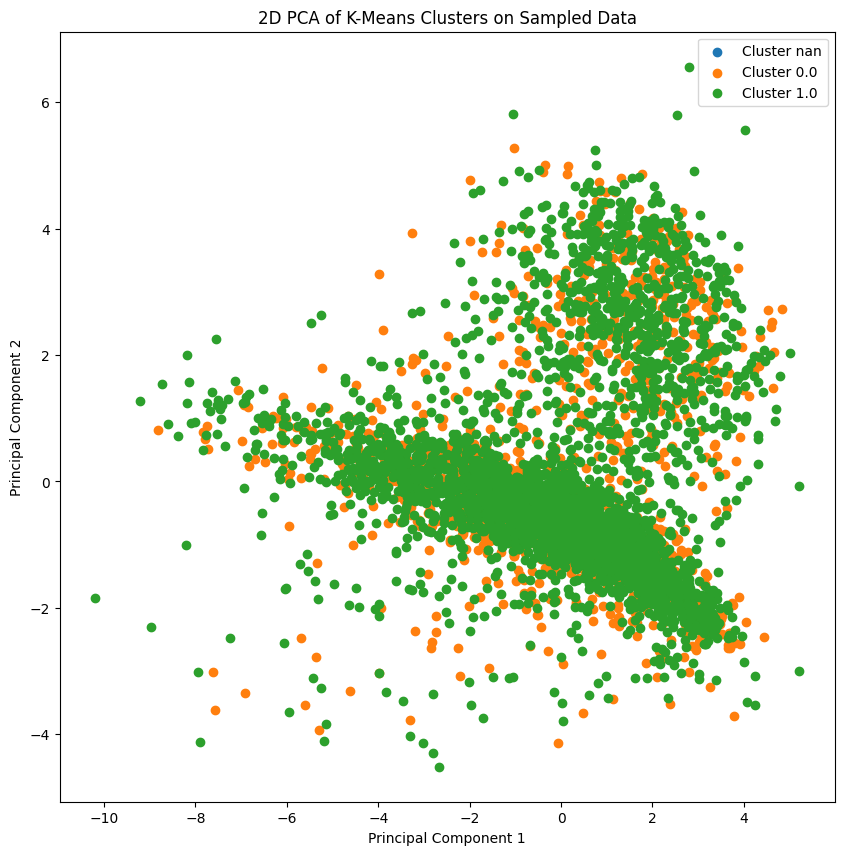

In [7]:
sample_size = 300000  
data_sample = data.sample(n=sample_size, random_state=42)
data_processed_sample = preprocessor.transform(data_sample)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_processed_sample)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['cluster'] = data_sample['KMeans_cluster']

plt.figure(figsize=(10,10))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of K-Means Clusters on Sampled Data')

for cluster in pca_df['cluster'].unique():
    plt.scatter(pca_df.loc[pca_df['cluster'] == cluster, 'PC1'], 
                pca_df.loc[pca_df['cluster'] == cluster, 'PC2'], 
                label=f'Cluster {cluster}')

plt.legend()
plt.show()

# Save to CSV

In [8]:
data.to_csv('labeled_augumented_cleaned_ar41_for_ulb.csv', index=True)